In [1]:
# Sentiment algorithm 1. Sequence of lemmas as single feature input and binary sentiment classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_1'
model_variant = 'base'

training_size = 3000000
test_size = 1000000

In [2]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import os
import time
import tensorflow as tf
from keras import callbacks

%reload_ext autoreload
%autoreload 2
from helpers.sentiment_functions import gender_seq_to_single
from helpers.sentiment_functions import equal_genders
from helpers.sentiment_functions import encode_feature
from helpers.sentiment_functions import plot_sentence_lengths
from helpers.sentiment_functions import plot_confusion_matrix_binary
from helpers.sentiment_functions import get_metrics
from helpers.sentiment_functions import xai_binary

pd.set_option('display.max_columns', 10, 'display.width', 15, 'display.max_colwidth', 15, 'display.max_rows',100)

In [3]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
3000000 samples are taken from the head for training
1000000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
2999995,404384,cool,cool,ADJ,0.037064,F
2999996,404384,factors,factor,NOUN,-0.055300,F
2999997,404384,like,like,ADP,-0.129606,F
2999998,404384,pore,pore,NOUN,0.000000,F


In [4]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_17884/3370681660.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_17884/3370681660.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,[organizati...,[organizati...,"[NOUN, VERB...",[-0.2230248...,F
1,2,"[Women, pre...","[woman, pre...","[NOUN, ADV,...",[0.27214283...,F
2,3,"[response, ...","[response, ...","[NOUN, NOUN...",[-0.0280537...,F
3,4,"[aware, all...","[aware, all...","[ADJ, NOUN,...",[-0.0157154...,F
4,5,"[point, Vis...","[point, Vis...","[NOUN, PROP...",[-0.2287299...,F
...,...,...,...,...,...,...
362024,404378,[Philosophy...,[philosophy...,"[NOUN, VERB...","[0.0, -0.25...",F
362025,404379,[Philosophy...,[Philosophy...,"[PROPN, NOU...","[0.0, 0.0, ...",F
362026,404381,"[Benefit, P...","[benefit, p...","[VERB, NOUN...",[-0.1672896...,F
362027,404383,[Pores],[Pores],[PROPN],[0.0],F


In [5]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,329288,"[brother, s...","[brother, s...","[NOUN, NOUN...",[0.01458027...,M
1,76715,"[want, Pres...","[want, Pres...","[VERB, PROP...",[-0.1587271...,F
2,315284,"[think, wom...","[think, wom...","[VERB, NOUN...",[-0.1442262...,F
3,377487,"[spoken, NB...","[speak, NBP...","[VERB, PROP...",[-0.0346027...,M
4,198586,"[Studies, C...","[study, Cas...","[NOUN, PROP...",[-0.1055170...,M
...,...,...,...,...,...,...
362024,47572,"[average, A...","[average, a...","[ADJ, VERB,...",[-0.1427406...,M
362025,166710,"[Durant, sa...","[Durant, sa...","[PROPN, VER...","[0.0, -0.56...",M
362026,73368,"[got, hang,...","[get, hang,...","[VERB, VERB...",[-0.1132411...,M
362027,170779,"[want, know...","[want, know...","[VERB, VERB...",[-0.1587271...,F


<AxesSubplot:>

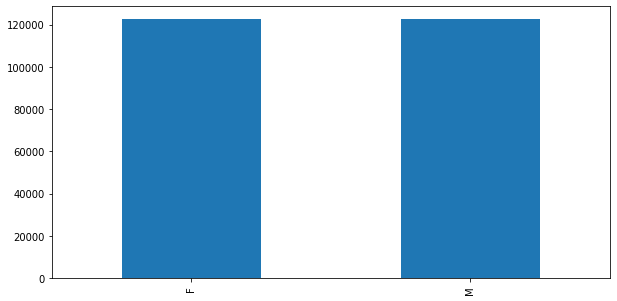

In [6]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

No handles with labels found to put in legend.


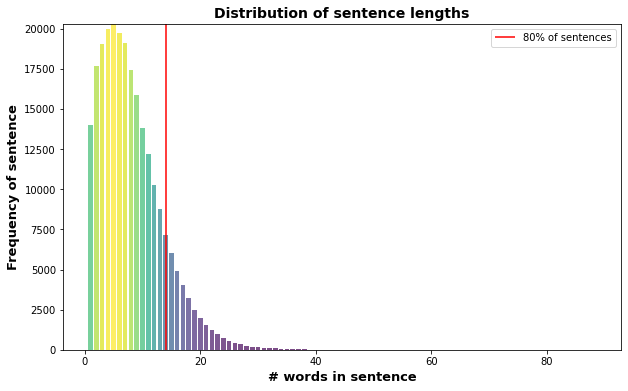

Decision boundary / 80 pct of sentence lengths is: 14


In [7]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [8]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size = encode_feature(train_data['Lemma'], test_data['Lemma'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [9]:
# ONE-HOT TARGET (GENDER)
le = LabelEncoder()
le.classes_ = ['M', 'F']

y_train = le.transform(train_data['Gender'])
y_test = le.transform(test_data['Gender'])

y_train = to_categorical(y_train)

print('[M] =', le.transform(['M']), '=', to_categorical(le.transform(['M']),2))
print('[F] =', le.transform(['F']), '=', to_categorical(le.transform(['F']),2))

[M] = [0] = [[1. 0.]]
[F] = [1] = [[0. 1.]]


In [12]:
# LOADING MODEL
from tensorflow import keras
model = keras.models.load_model('saved_models/sent_algo_1/base_v2.h5')

In [13]:
# PREDICT TEST DATA
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = y_pred.flatten()
y_pred

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

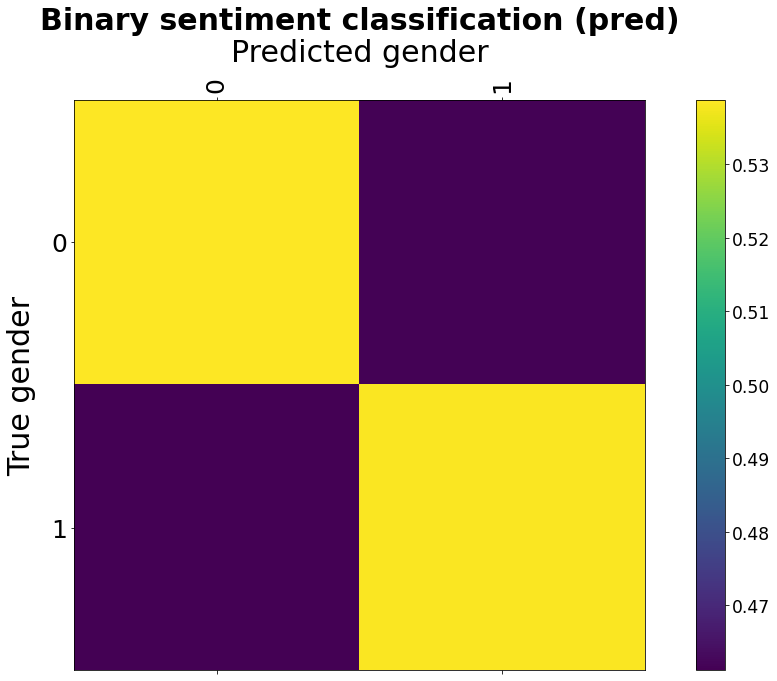

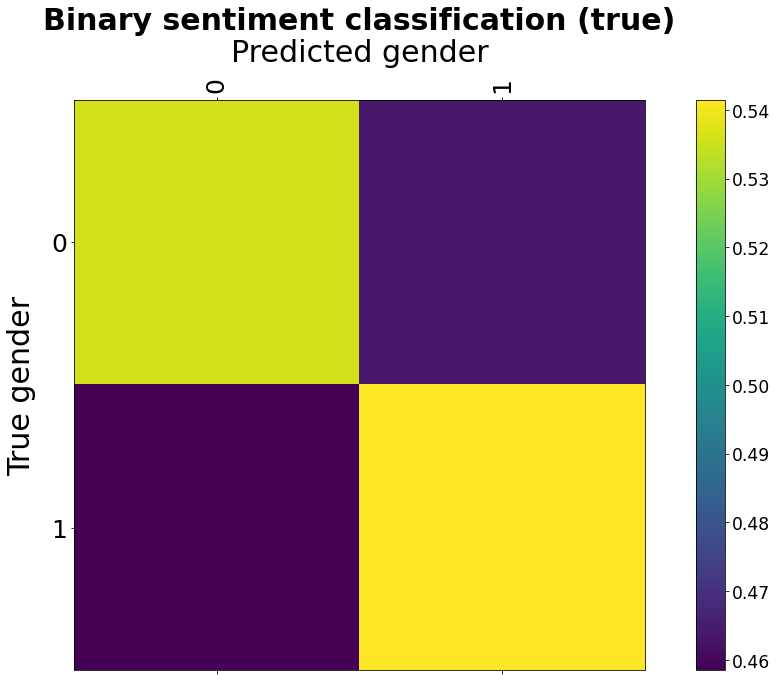

In [14]:
# PLOTTING CONFUSION MATRIX
plot_confusion_matrix_binary(np.array(y_test).flatten(), y_pred, 'Binary sentiment classification', 'Predicted gender', 'True gender')

In [15]:
# PRINTING METRICS
sentiment_vocab = ['M', 'F']
get_metrics(y_test, y_pred, sentiment_vocab, 'Gender')

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\BAC\Ezra\sentiment\models\helpers\sentiment_functions.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.54,0.54,0.54,51779.0
1,F,0.54,0.54,0.54,51779.0


In [16]:
# USE XAI ON PREDICTIONS
xai_binary(y_pred[:100], test_data, 2)


---------------------------------------------------------------------------------------
The sentence: "While Congress could amend the Federal Arbitration Act, this does not appear likely.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'amend' with a polarity of 0.0
'Arbitration' with a polarity of 0.0

---------------------------------------------------------------------------------------
The sentence: "A gasoline black market is emerging on Craigslist, where hoarders are offering gasoline for as much as $30 a gallon.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'black' with a polarity of 0.04
'hoarders' with a polarity of 0.0

---------------------------------------------------------------------------------------
The sentence: ""I've seen a lot of those so move up in front," he said.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

've' with a polarity of 0.0
'seen' with a polarity of -0.06

------